In [1]:
from PIL import Image
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
landMaskIm = Image.open('land_mask.png').convert('LA')
realMapIm = Image.open('BW_map.png').convert('LA')
landMaskIm_flip = landMaskIm.transpose(Image.FLIP_LEFT_RIGHT)
realMapIm_flip = realMapIm.transpose(Image.FLIP_LEFT_RIGHT)

#realMapIm.show()

#landMaskIm.size

## Find squares of the land mask that have both water and land

In [3]:
npLMI = np.array(landMaskIm)[:,:,0]
npLMIF = np.array(landMaskIm_flip)[:,:,0]
allNpLMI = np.concatenate([npLMI,npLMIF], axis=0)
npCMI = np.array(realMapIm)[:,:,0]
npCMIF = np.array(realMapIm_flip)[:,:,0]
allNpCMI = np.concatenate([npCMI,npCMIF], axis=0)
#print(npLMI)
print(0 in npLMI, 255 in npLMI, 120 in npLMI)
print(allNpLMI.shape)
print(allNpCMI.shape)

True True False
(2030, 1831)
(2030, 1831)


In [4]:
nPics = 10000
subSquareSize = (96,96) # Must be multiple of 4!
maskSubSquares = np.zeros((nPics, subSquareSize[0], subSquareSize[1]))
realSubSquares = np.zeros((nPics, subSquareSize[0], subSquareSize[1]))
subSquareCoords = []
validSquareIndex = 0
while validSquareIndex < nPics:
    xCoord = np.random.randint(0,allNpLMI.shape[0]-subSquareSize[0])
    yCoord = np.random.randint(0,allNpLMI.shape[1]-subSquareSize[1])
    #print(xCoord, yCoord)
    candidateSubSquare = allNpLMI[xCoord:xCoord+subSquareSize[0],
                                  yCoord:yCoord+subSquareSize[1]]
    if 25 < np.mean(candidateSubSquare) < 225:
        #print(candidateSubSquare.shape)
        #print(candidateSubSquare)
        subSquareCoords.append((xCoord, yCoord))
        maskSubSquare =  allNpLMI[xCoord:xCoord+subSquareSize[0],
                                  yCoord:yCoord+subSquareSize[1]]
        maskSubSquares[validSquareIndex] = maskSubSquare
        
        realSubSquare =  allNpCMI[xCoord:xCoord+subSquareSize[0],
                                  yCoord:yCoord+subSquareSize[1]]
        realSubSquare = realSubSquare * (maskSubSquare > 225)
        realSubSquares[validSquareIndex] = realSubSquare

        validSquareIndex += 1


## Check results of search

<IPython.core.display.Javascript object>


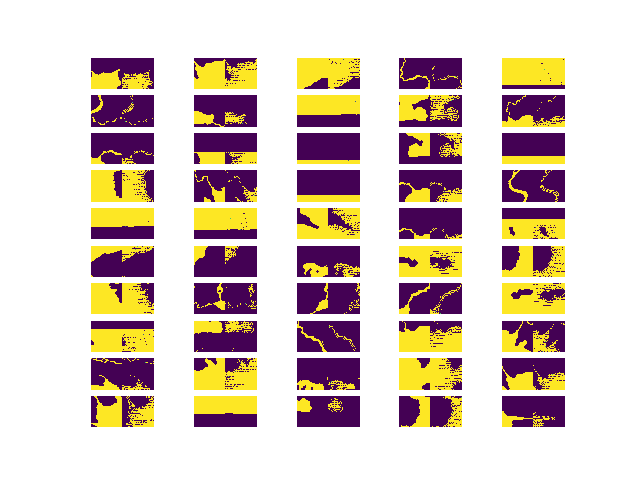

In [25]:
nPicsToShow = 50
nCols = 5
nRows = (nPicsToShow+1) / (nCols)
for i in range(nPicsToShow):
    xCoord = subSquareCoords[i][0]
    yCoord = subSquareCoords[i][1]
    plt.subplot(nRows, nCols, i+1)
    #maskSubSquare = npLMI[xCoord:xCoord+subSquareSize[0],
    #                      yCoord:yCoord+subSquareSize[1]]
    plt.imshow(np.concatenate([maskSubSquares[i],realSubSquares[i]], axis=1))
    #plt.subplot(nRows, nCols, (i*2)+2)
    #realSubSquare = npCMI[xCoord:xCoord+subSquareSize[0],
    #                      yCoord:yCoord+subSquareSize[1]]
    #plt.imshow(realSubSquares[i])
    plt.axis('off')
    
# tight_layout minimizes the overlap between 2 sub-plots
#plt.tight_layout()
#plt.tight_layout()
plt.show()

## Start machine learning

In [5]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
import keras
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.


In [6]:
X_train = maskSubSquares
Y_train = realSubSquares

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
max_X = np.max(X_train)
factor = max_X / 2
X_train = (X_train - factor) / factor

max_Y = np.max(Y_train)
factor = max_X / 2
Y_train = (Y_train - factor) / factor

In [ ]:
## Original
generator = Sequential([
        Dense((subSquareSize[0]/4)*(subSquareSize[1]/4)*16, 
              input_dim=subSquareSize[0]*subSquareSize[1], 
              activation=LeakyReLU(0.2)),
        BatchNormalization(),
        Reshape((subSquareSize[0]/4,subSquareSize[0]/4,16)),
        UpSampling2D(),
        Convolution2D(8, (5, 5), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        UpSampling2D(),
        Convolution2D(1, (5, 5), padding='same', activation='tanh')
    ])
generator.summary()

In [7]:
# One to use for waterways
denseShrinkFactor = 16
generator = Sequential([
        #BatchNormalization(),
        Convolution2D(8, (15, 15), input_shape=(subSquareSize[0],subSquareSize[1],1), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        AveragePooling2D((denseShrinkFactor,denseShrinkFactor)),
        Reshape((subSquareSize[0]*subSquareSize[1]*8/(denseShrinkFactor**2),), 
                input_shape=(subSquareSize[0]/denseShrinkFactor,
                             subSquareSize[1]/denseShrinkFactor,
                             8)),
        Dense((subSquareSize[0]*subSquareSize[1]*8/(denseShrinkFactor**2)), 
              input_dim=(subSquareSize[0]*subSquareSize[1]*8/(denseShrinkFactor**2)), 
              activation=LeakyReLU(0.2)),
        Reshape((subSquareSize[0]/denseShrinkFactor,subSquareSize[1]/denseShrinkFactor,8), 
                input_shape=(subSquareSize[0]*subSquareSize[1]*8/(denseShrinkFactor**2),)),
        UpSampling2D((denseShrinkFactor,denseShrinkFactor)),
        Convolution2D(8, (15, 15), padding='same', activation=LeakyReLU(0.2)),
        BatchNormalization(),
        #UpSampling2D(),
        Convolution2D(1, (5, 5), padding='same', activation='tanh'),
        #Concatenate()
    
    ])
generator.summary()

/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 8)         1808      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 8)         32        
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 8)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               83232     
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 6, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 8)         0         
__________

In [8]:
discriminator = Sequential([
        Convolution2D(64, 15, 15, subsample=(2,2), 
                      input_shape=(subSquareSize[0]*2,subSquareSize[1],1), 
                      border_mode='same', 
                      activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Convolution2D(128, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU(0.2)),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
discriminator.summary()

/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (15, 15), padding="same", strides=(2, 2), activation=<keras.lay..., input_shape=(192, 96, ...)`
  """
/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 48, 64)        14464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 24, 128)       204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 24, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 147457    
Total params: 366,849
Trainable params: 366,849
Non-trainable params: 0
_________________________________________________________________


In [9]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

In [11]:
discriminator.trainable = False
ganInput = Input(shape=(subSquareSize[0], subSquareSize[1],1))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
#catLayer = Sequential()
#discInput = Concatenate([x,ganInput], input_shape=(subSquareSize[0]*2, subSquareSize[1]))
#catLayer.add(Concatenate([ganInput,ganInput,ganInput], input_shape=(subSquareSize[0]*2, subSquareSize[1])))
#catLayer.add(keras.layers.concatenate([x,ganInput], input_shape=(subSquareSize[0]*2, subSquareSize[1])))
discInput = keras.layers.concatenate([x,ganInput], 
                                     axis=1,
                                     input_shape=(subSquareSize[0]*2, subSquareSize[1]))
#discInput = Input([x,ganInput])
ganOutput = discriminator(discInput)
#ganOutput = discriminator(x)

gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

/Users/jeffreywagner/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`


In [12]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 96, 96, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 96, 96, 1)     99713       input_1[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 192, 96, 1)    0           sequential_1[1][0]               
                                                                   input_1[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             366849      concatenate_1[0][0]     

In [13]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            #noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            mask_image_batch = np.zeros((batch_size, subSquareSize[0],subSquareSize[1],1))
            for i in range(batch_size):
                mask_image_batch[i,:,:,0] = X_train[image_batch_indices[i],:,:]#.flatten()
            #mask_image_batch = X_train[image_batch_indices]
            #print('mask_image_batch.shape', mask_image_batch.shape)
            real_image_batch = np.zeros((batch_size, subSquareSize[0], subSquareSize[1], 1))
            real_image_batch[:,:,:,0] = Y_train[image_batch_indices]
            
            # these are the predicted images from the generator
            predictions = generator.predict(mask_image_batch, batch_size=batch_size)#[:,:,:,0]
            predictionsAndMasks = np.concatenate([predictions, mask_image_batch], axis=1)
            realImagesAndMasks = np.concatenate([real_image_batch, mask_image_batch], axis=1)
            # the discriminator takes in the real images and the generated images
            #print(predictions.shape, real_image_batch.shape)
            #X = np.concatenate([predictions, real_image_batch], axis=0)
            #print('X.shape', X.shape)
            X = np.concatenate([predictionsAndMasks, realImagesAndMasks], axis=0)
            #X = np.concatenate([predictions, real_image_batch], axis=0)
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            loss = discriminator.train_on_batch(X, y_discriminator)
            # Let's train the generator
            #noise_input = np.random.rand(batch_size, 100)
            image_batch_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            mask_image_batch_2 = np.zeros((batch_size, subSquareSize[0],subSquareSize[1],1))
            for i in range(batch_size):
                mask_image_batch_2[i,:,:,0] = X_train[image_batch_indices[i],:,:]#.flatten()
            discriminator.trainable = False
            y_generator = [1]*batch_size
            gan.train_on_batch(mask_image_batch_2, y_generator)
        print('epoch %i loss %f' %(i, loss))


In [14]:
train(30, 128)

  3%|▎         | 2/78 [04:31<2:51:59, 135.78s/it]

KeyboardInterrupt: 

In [ ]:
def plot_output():
    nToPlot = 25
    #try_input = (np.random.rand(100,subSquareSize[0]*subSquareSize[1]))
    #try_input = np.zeros((100,100)) + 1
    #try_input[30:70,:] += 1.5
    #try_input[70:100,:] += 2.5
    #try_input = np.array(try_input)
    image_batch_indices = np.random.randint(0, X_train.shape[0], size=nToPlot)
    mask_image_batch = np.zeros((nToPlot, subSquareSize[0],subSquareSize[1],1))
    for i in range(nToPlot):
        mask_image_batch[i,:,:,0] = X_train[image_batch_indices[i],:,:]#.flatten()
    preds = generator.predict(mask_image_batch)
    predsAndMasks = np.concatenate([mask_image_batch, preds], axis=1)
    #preds = generator.predict(np.array([[1]*10,2,2,2,3,3,3]))
    plt.clf()
    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(5, 5, i+1)
        #plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.imshow(predsAndMasks[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

In [ ]:
plot_output()

In [ ]:
print('Saving 30')
generator.save_weights('2018_06_04_waterways_gen_30.h5')
discriminator.save_weights('2018_06_04_waterways_dis_30.h5')
#plot_output()
train(30, 128)
print('Saving 60')
generator.save_weights('2018_06_04_waterways_gen_60.h5')
discriminator.save_weights('2018_06_04_waterways_dis_60.h5')
#plot_output()
train(30, 128)
print('Saving 90')
generator.save_weights('2018_06_04_waterways_gen_90.h5')
discriminator.save_weights('2018_06_04_waterways_dis_90.h5')
train(30, 128)
#plot_output()
print('Saving 120')
generator.save_weights('2018_06_04_waterways_gen_120.h5')
discriminator.save_weights('2018_06_04_waterways_dis_120.h5')
train(30, 128)
#plot_output()
print('Saving 150')
generator.save_weights('2018_06_04_waterways_gen_150.h5')
discriminator.save_weights('2018_06_04_waterways_dis_150.h5')
#plot_output()

In [ ]:
batch_size = 10
# getting random images from X_train of size=batch_size 
# these are the real images that will be fed to the discriminator
image_batch_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
mask_image_batch = np.zeros((batch_size, subSquareSize[0],subSquareSize[1],1))
for i in range(batch_size):
    mask_image_batch[i,:,:,0] = X_train[image_batch_indices[i],:,:]#.flatten()
#mask_image_batch = X_train[image_batch_indices]
#print('mask_image_batch.shape', mask_image_batch.shape)
real_image_batch = np.zeros((batch_size, subSquareSize[0], subSquareSize[1], 1))
real_image_batch[:,:,:,0] = Y_train[image_batch_indices]
            
# these are the predicted images from the generator
predictions = generator.predict(mask_image_batch, batch_size=batch_size)#[:,:,:,0]
predictionsAndMasks = np.concatenate([predictions, mask_image_batch], axis=1)
realImagesAndMasks = np.concatenate([real_image_batch, mask_image_batch], axis=1)
# the discriminator takes in the real images and the generated images
#print(predictions.shape, real_image_batch.shape)
#X = np.concatenate([predictions, real_image_batch], axis=0)
#print('X.shape', X.shape)
X = np.concatenate([predictionsAndMasks, realImagesAndMasks], axis=2)
#X = np.concatenate([predictions, real_image_batch], axis=0)
            
# labels for the discriminator
y_discriminator = [0]*batch_size + [1]*batch_size
            
# Let's train the discriminator
discriminator.trainable = True
result = discriminator.train_on_batch(X, y_discriminator)


# See why this doesn't look so great

In [ ]:
print(discriminator.metrics_names)
print(result)
plt.clf()
plt.figure(figsize=(10,10))
for i in range(X.shape[0]):
    plt.subplot(5, 5, i+1)
    #plt.imshow(preds[i, :, :, 0], cmap='gray')
    #plt.imshow(predictionsAndMasks[i, :, :, 0], cmap='gray')
    plt.imshow(X[i, :, :, 0], cmap='gray')
    plt.axis('off')
    
# tight_layout minimizes the overlap between 2 sub-plots
plt.tight_layout()

# I think this means the discriminator is too good